In [1]:
%matplotlib inline

import http.client
import json
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pika
import time
from ipywidgets import interact

# from bokeh.plotting import output_file, figure, show, hplot

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import output_file, figure, show, output_notebook
from bokeh.models import ColumnDataSource, CustomJS, Rect

from six.moves import zip

output_notebook()

source = ColumnDataSource({'x': [], 'y': [], 'width': [], 'height': []})

Loading BokehJS ...

In [2]:
# backend service connection
baseEndpoint = "localhost:8082" 
basePath = "/2d/scatter"
baseUri = baseEndpoint + basePath

# rabbitMQ connection
credentials = pika.PlainCredentials("user", "password")
parameters = pika.ConnectionParameters('localhost', 5672, '/', credentials)

# setting up exchange and queue

#channel = connection.channel()
#channel.exchange_declare(exchange='BDAPRO', exchange_type='direct')
#
#result = channel.queue_declare(exclusive=True)
#queue_name = result.method.queue

In [3]:
# functions

def getData(x=100,y=100):
    relativePath = "{}?x={}&y={}".format(basePath,x,y)
    conn = http.client.HTTPConnection(baseEndpoint)
    conn.request("GET", relativePath)
    r1 = conn.getresponse()

    if (r1.status >= 400):
        print("Error:", relativePath, r1.status, r1.reason)
        return []
    else:
        payload = r1.read()
        jsonPayload = payload.decode('utf-8')
        return json.loads(jsonPayload)
    

def scatterPlot(data):
    grid = np.array(data)
    plt.scatter(grid[:,0], grid[:,1], c='b', marker='.', s=1)
    plt.title('Optimized Scatter Plot')
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.show()
    plt.close()

In [4]:
xDim = 1000
yDim = 1000
data = getData(xDim,yDim)

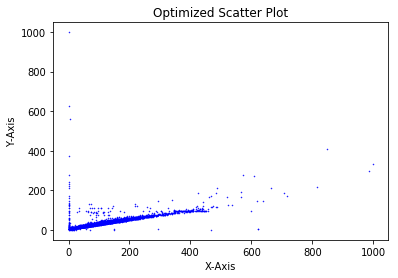

In [5]:
scatterPlot(data)

In [6]:
MESSAGE_DELAY_SECONDS = 1
RADIUS = 3

def get_colors(x, y):
    return ["#%02x%02x%02x" % (int(float(red / xDim) * 255), int(float(green / yDim) * 255), 150) for red, green in zip(x, y)]

def consumeQueue(ch, method, properties, body):
    print(" [x] Consuming Queue Message:%r" % (method.routing_key))
    
    # parse message; e.g. {"data":[[719,0,0,536, ... ,0,0]]}
    jsonPayload = body.decode('utf-8')
    data = json.loads(jsonPayload)
    
    # acknowledge message received
    # ch.basic_ack(delivery_tag = method.delivery_tag)
    
    # scatterPlot(data)

    # convert data
    grid = np.array(data)
    x = grid[:,0]
    y = grid[:,1]
    radii = grid[:,2]
    #colors = ["#%02x%02x%02x" % (int(red % 255), int(green % 255), 150) for red, green in zip(50+2*x, 30+2*y)]
    # ["#%02x%02x%02x" % (int(float(red / xDim) * 150), int(float(green / yDim) * 150), 150) for red, green in zip(distance, fair)]
    colors = get_colors(x, y)
    
    # update plot
    r.data_source.data['x'] = x
    r.data_source.data['y'] = y
    r.data_source.data['radius'] = [(radius % RADIUS) for radius in radii]
    r.data_source.data['fill_color'] = colors
    
    # time.sleep(MESSAGE_DELAY_SECONDS)
    push_notebook()
    



In [7]:
grid = np.array(data)

TOOLS="hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select,poly_select,lasso_select"

distance = grid[:,0]
fair = grid[:,1]
radii = grid[:,2]
# ["#%02x%02x%02x" % (int((red / xDim) * 255), int((green / yDim) * 255), 150) for red, green in zip(50+2*distance, 30+2*fair)]
colors = get_colors(distance, fair)

size = grid.shape[0] # amount of data points

p = figure(title="Optimized Visaulization Pipeline: Taxi Data", width=500, height=500, tools=TOOLS,
          x_axis_label='distance', y_axis_label='fair amount')
r = p.scatter(x = distance, y = fair, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)

In [8]:
show(p, notebook_handle=True)

In [9]:
# for plots read: http://bokeh.pydata.org/en/latest/docs/user_guide/notebook.html

connection = pika.BlockingConnection(parameters)
channel = connection.channel()


In [10]:
#run = 1
#
#def consume():
#    while(run):
#        channel.basic_consume(consumeQueue, queue='BDAPRO', no_ack=True)
#        time.sleep(MESSAGE_DELAY_SECONDS)

channel.basic_consume(consumeQueue, queue='BDAPRO', no_ack=True)        
channel.start_consuming()

 [x] Consuming Queue Message:'plot.2d'


KeyboardInterrupt: 

In [ ]:
connection.close()

In [26]:
def update(q, f, x=10, y=10, radius=3):
    RADIUS = radius
    ## pull data from queue
    # r.data_source.data['x'] = np.random.random(size=x) * x
    # r.data_source.data['y'] = np.random.random(size=y) * y
    # r.data_source.data['radius'] = np.random(size=radius) * radius
    # push_notebook()

In [27]:
interact(update, q=["taxi data", "????"], f=["scatter", "cluster"], x=(10,4000), y=(10,4000), radius=(1,10))

<function __main__.update>

also see for growing (appending) scatter plots: https://stackoverflow.com/questions/43101497/how-do-stream-data-to-a-bokeh-plot-in-jupyter-with-a-high-refresh-rate



In [39]:
# p1.x_range.callback = CustomJS(args=dict(source=source, range=p1.x_range), code=jscode % ('x', 'width'))
# p1.y_range.callback = CustomJS(args=dict(source=source, range=p1.y_range), code=jscode % ('y', 'height'))